# Data Cleaning

### Import Relevant Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
import sklearn.linear_model as lr
from IPython.display import Markdown, display

### Read in housing data csv

In [2]:
house = pd.read_csv('./data/kc_house_data.csv')

In [3]:
display(Markdown('./data/column_names.md'))

# Column Names and Descriptions for King County Data Set
* `id` - Unique identifier for a house
* `date` - Date house was sold
* `price` - Sale price (prediction target)
* `bedrooms` - Number of bedrooms
* `bathrooms` - Number of bathrooms
* `sqft_living` - Square footage of living space in the home
* `sqft_lot` - Square footage of the lot
* `floors` - Number of floors (levels) in house
* `waterfront` - Whether the house is on a waterfront
  * Includes Duwamish, Elliott Bay, Puget Sound, Lake Union, Ship Canal, Lake Washington, Lake Sammamish, other lake, and river/slough waterfronts
* `view` - Quality of view from house
  * Includes views of Mt. Rainier, Olympics, Cascades, Territorial, Seattle Skyline, Puget Sound, Lake Washington, Lake Sammamish, small lake / river / creek, and other
* `condition` - How good the overall condition of the house is. Related to maintenance of house.
  * See the [King County Assessor Website](https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r) for further explanation of each condition code
* `grade` - Overall grade of the house. Related to the construction and design of the house.
  * See the [King County Assessor Website](https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r) for further explanation of each building grade code
* `sqft_above` - Square footage of house apart from basement
* `sqft_basement` - Square footage of the basement
* `yr_built` - Year when house was built
* `yr_renovated` - Year when house was renovated
* `zipcode` - ZIP Code used by the United States Postal Service
* `lat` - Latitude coordinate
* `long` - Longitude coordinate
* `sqft_living15` - The square footage of interior housing living space for the nearest 15 neighbors
* `sqft_lot15` - The square footage of the land lots of the nearest 15 neighbors


In [4]:
house.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


### Convert date type to datetime

In [5]:
house.date = pd.to_datetime(house.date)

In [6]:
house['month'] = house.date.dt.month

### Split grade into 2 columns of a categorical (grade) and a number value (grade_value)

In [7]:
house[['grade_value', 'grade']] = house.grade.str.split(" ",1, expand=True)

### Convert grade_value to int

In [8]:
house.grade_value = house.grade_value.astype({'grade_value':'int64'})

### Update sqft_basement by taking sqft_living - sqft_above to replace '?'s with the actual value

In [9]:
#Add new sqft_basement column
house['sqft_basement'] = house.sqft_living - house.sqft_above

### Removed row of bad data where bedrooms was 33

In [10]:
house.drop(house[house.bedrooms == 33].index,inplace=True)

### Impute waterfront for missing values dependent on quality of the view

In [11]:
#Create new df of all the missing waterfront values to see how to impute missing values
missing_waterfront = house[(house.waterfront != 'YES') & (house.waterfront != 'NO')]

In [12]:
#See the value counts of views for the waterfront values that are missing
missing_waterfront.view.value_counts()

NONE         2110
AVERAGE       121
GOOD           73
FAIR           39
EXCELLENT      27
Name: view, dtype: int64

### Create dictionary of views and convert to 0-4 scale

In [13]:
#View dictionary
view_dict = {'NONE': 0, 'FAIR': 1, 'AVERAGE': 2, 'GOOD': 3, 'EXCELLENT': 4}

#Replace string key, values
house.replace({'view':view_dict},inplace=True)

### Impute missing values for waterfront based on level of view

In [14]:
#Good or Excellent views make waterfront equal to YES
house.loc[(house.waterfront.isna()) & ((house.view == 'EXCELLENT') | (house.view == 'GOOD')),'waterfront'] = 'YES'

In [15]:
#Any other view make waterfront equal to NO
house.loc[house.waterfront.isna(),'waterfront'] = 'NO'

In [16]:
#Set waterfront YES to 1 and NO to 0 to make waterfront numerical
house.loc[house.waterfront == 'YES','waterfront'] = 1
house.loc[house.waterfront == 'NO','waterfront'] = 0

### Impute missing values for view based on waterfront

In [17]:
#If there is a waterfront set the view equal to EXCELLENT - 4
house.loc[(house.view.isna()) & (house.waterfront == 1),'view'] = 4

#If there is not a waterfront set the view equal to NONE - 0
house.loc[(house.view.isna()) & (house.waterfront == 0),'view'] = 0

### Convert waterfront 0s and 1s to int

In [18]:
house.waterfront = house.waterfront.astype('int64')

### Update condition to put on a 1-5 number scale

In [19]:
#Condition dictionary
condition_dict = {'Poor': 1, 'Fair': 2, 'Average': 3, 'Good': 4, 'Very Good': 5}

# Replace string key, values
house.replace({'condition':condition_dict},inplace=True)

### Impute all missing yr_renovated as 0

In [20]:
house.loc[house.yr_renovated.isna(),'yr_renovated'] = 0

### Create new column of the number of years since renovation

#### If a house was not renovated, the yr since renovation is 2015 - the year built 

In [21]:
#Apply lambda function if yr_renovated is greater than 0 or equal to 0
house['yr_since_renovate'] = house.apply(lambda row: 2015-row.yr_renovated if row['yr_renovated'] > 0 else 2015-row.yr_built, axis = 1)


### Create correlation table of all features against price

In [22]:
#Get correlation table of all numeric values of the housing data
corr_mat = house.corr(method='pearson')

#Get top right part of correlation table
upper_corr_mat = corr_mat.where(
    np.triu(np.ones(corr_mat.shape), k=1).astype(bool))

#Drop the non top right part and unstack the data
unique_corr = upper_corr_mat.unstack().dropna()

#Sort the values and get absolute values to account for negative correlation
sort_corr = unique_corr.abs().sort_values(ascending=False)

#Convert to data frame
new_corr = sort_corr.to_frame().reset_index()

#Make correlation data frame with just correlations that contain price
price_corr = new_corr[(new_corr.level_0 == 'price') | (new_corr.level_1 == 'price')]

#Rename columns
price_corr.columns = ['feature1','feature2','corr']

### Ranked features correlated with price

In [23]:
price_corr

,feature1,feature2,corr
9,sqft_living,price,0.701929
11,grade_value,price,0.667964
13,sqft_above,price,0.605392
15,sqft_living15,price,0.585267
20,bathrooms,price,0.525915
35,view,price,0.396419
49,sqft_basement,price,0.323794
51,bedrooms,price,0.315961
53,lat,price,0.306687
61,waterfront,price,0.264308


In [24]:
cols = list(price_corr.feature1[0:-2])

In [25]:
top = house[cols]
top

,sqft_living,grade_value,sqft_above,sqft_living15,bathrooms,view,sqft_basement,bedrooms,lat,waterfront,floors,yr_renovated,yr_since_renovate,sqft_lot,sqft_lot15,yr_built,zipcode,condition,long
0,1180,7,1180,1340,1.00,0.0,0,3,47.5112,0,1.0,0.0,60.0,5650,5650,1955,98178,3,-122.257
1,2570,7,2170,1690,2.25,0.0,400,3,47.7210,0,2.0,1991.0,24.0,7242,7639,1951,98125,3,-122.319
2,770,6,770,2720,1.00,0.0,0,2,47.7379,0,1.0,0.0,82.0,10000,8062,1933,98028,3,-122.233
3,1960,7,1050,1360,3.00,0.0,910,4,47.5208,0,1.0,0.0,50.0,5000,5000,1965,98136,5,-122.393
4,1680,8,1680,1800,2.00,0.0,0,3,47.6168,0,1.0,0.0,28.0,8080,7503,1987,98074,3,-122.045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,1530,8,1530,1530,2.50,0.0,0,3,47.6993,0,3.0,0.0,6.0,1131,1509,2009,98103,3,-122.346
21593,2310,8,2310,1830,2.50,0.0,0,4,47.5107,0,2.0,0.0,1.0,5813,7200,2014,98146,3,-122.362
21594,1020,7,1020,1020,0.75,0.0,0,2,47.5944,0,2.0,0.0,6.0,1350,2007,2009,98144,3,-122.299
21595,1600,8,1600,1410,2.50,0.0,0,3,47.5345,0,2.0,0.0,11.0,2388,1287,2004,98027,3,-122.069


In [37]:
#Write data to csv for continued use in other notebooks
house.to_csv('./data/clean_house.csv')

In [26]:
y = house.price
x = top[cols]

model = sm.OLS(endog=y,exog=sm.add_constant(x)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.701
Model:                            OLS   Adj. R-squared:                  0.701
Method:                 Least Squares   F-statistic:                     2809.
Date:                Mon, 05 Dec 2022   Prob (F-statistic):               0.00
Time:                        21:03:46   Log-Likelihood:            -2.9434e+05
No. Observations:               21596   AIC:                         5.887e+05
Df Residuals:                   21577   BIC:                         5.889e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              6.833e+06   2.98e+06      2.296      0.022    9.99e+05    1.27e+07
sqft_living         111.2939      2.286     48.687      0.000     106.813     115.775
grade_value        9.632e+04   2162.384     44.543      0.000    9.21e+04    1.01e+05
sqft_above           71.4547      2.256     31.667      0.000      67.032      75.877
sqft_living15        21.3210      3.448      6.184      0.000      14.564      28.078
bathrooms           4.27e+04   3269.582     13.058      0.000    3.63e+04    4.91e+04
view               5.424e+04   2122.653     25.552      0.000    5.01e+04    5.84e+04
sqft_basement        39.8307      2.649     15.039      0.000      34.639      45.022
bedrooms          -3.921e+04   1977.870    -19.825      0.000   -4.31e+04   -3.53e+04
lat                6.001e+05   1.07e+04     55.935      0.000    5.79e+05    6.21e+05
waterfront         6.114e+05   1.82e+04     33.668      0.000    5.76e+05    6.47e+05
floors             7018.1157   3602.683      1.948      0.051     -43.409    1.41e+04
yr_renovated         29.0753      9.721      2.991      0.003      10.021      48.130
yr_since_renovate   209.2353    320.337      0.653      0.514    -418.649     837.120
sqft_lot              0.1255      0.048      2.622      0.009       0.032       0.219
sqft_lot15           -0.3958      0.073     -5.403      0.000      -0.539      -0.252
yr_built          -2441.4260    316.389     -7.717      0.000   -3061.572   -1821.280
zipcode            -589.4308     32.951    -17.888      0.000    -654.017    -524.845
condition          2.654e+04   2349.943     11.293      0.000    2.19e+04    3.11e+04
long              -2.173e+05   1.31e+04    -16.533      0.000   -2.43e+05   -1.92e+05
==============================================================================
Omnibus:                    18220.041   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1795477.121
Skew:                           3.528   Prob(JB):                         0.00
Kurtosis:                      47.109   Cond. No.                     5.12e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 8.36e-22. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [27]:
top_10 = price_corr[0:10]
top_10 = house[list(top_10.feature1)]
top_10

,sqft_living,grade_value,sqft_above,sqft_living15,bathrooms,view,sqft_basement,bedrooms,lat,waterfront
0,1180,7,1180,1340,1.00,0.0,0,3,47.5112,0
1,2570,7,2170,1690,2.25,0.0,400,3,47.7210,0
2,770,6,770,2720,1.00,0.0,0,2,47.7379,0
3,1960,7,1050,1360,3.00,0.0,910,4,47.5208,0
4,1680,8,1680,1800,2.00,0.0,0,3,47.6168,0
...,...,...,...,...,...,...,...,...,...,...
21592,1530,8,1530,1530,2.50,0.0,0,3,47.6993,0
21593,2310,8,2310,1830,2.50,0.0,0,4,47.5107,0
21594,1020,7,1020,1020,0.75,0.0,0,2,47.5944,0
21595,1600,8,1600,1410,2.50,0.0,0,3,47.5345,0


<AxesSubplot:>

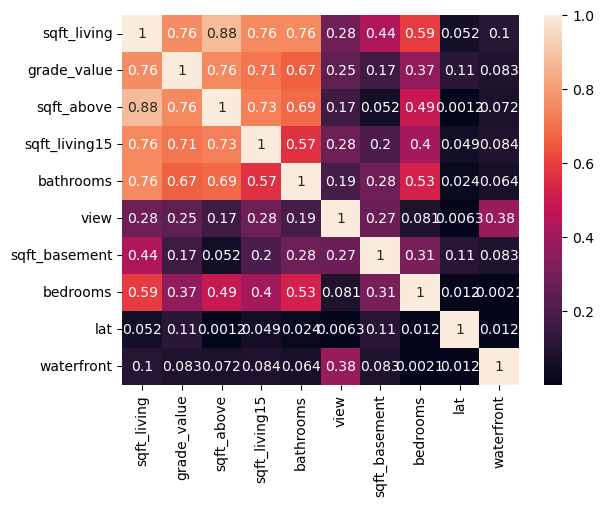

In [28]:
sns.heatmap(top_10.corr().abs(),annot=True)

<AxesSubplot:xlabel='sqft_living', ylabel='price'>

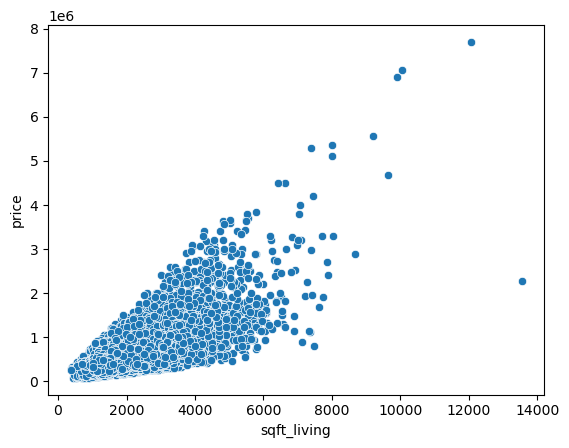

In [29]:
sns.scatterplot(x=house.sqft_living,y=house.price)

In [30]:
house[house.sqft_lot == house.sqft_lot.max()]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month,grade_value,yr_since_renovate
1717,1020069017,2015-03-27,700000.0,4,1.0,1300,1651359,1.0,0,3.0,...,1920,0.0,98022,47.2313,-122.023,2560,425581,3,6,95.0


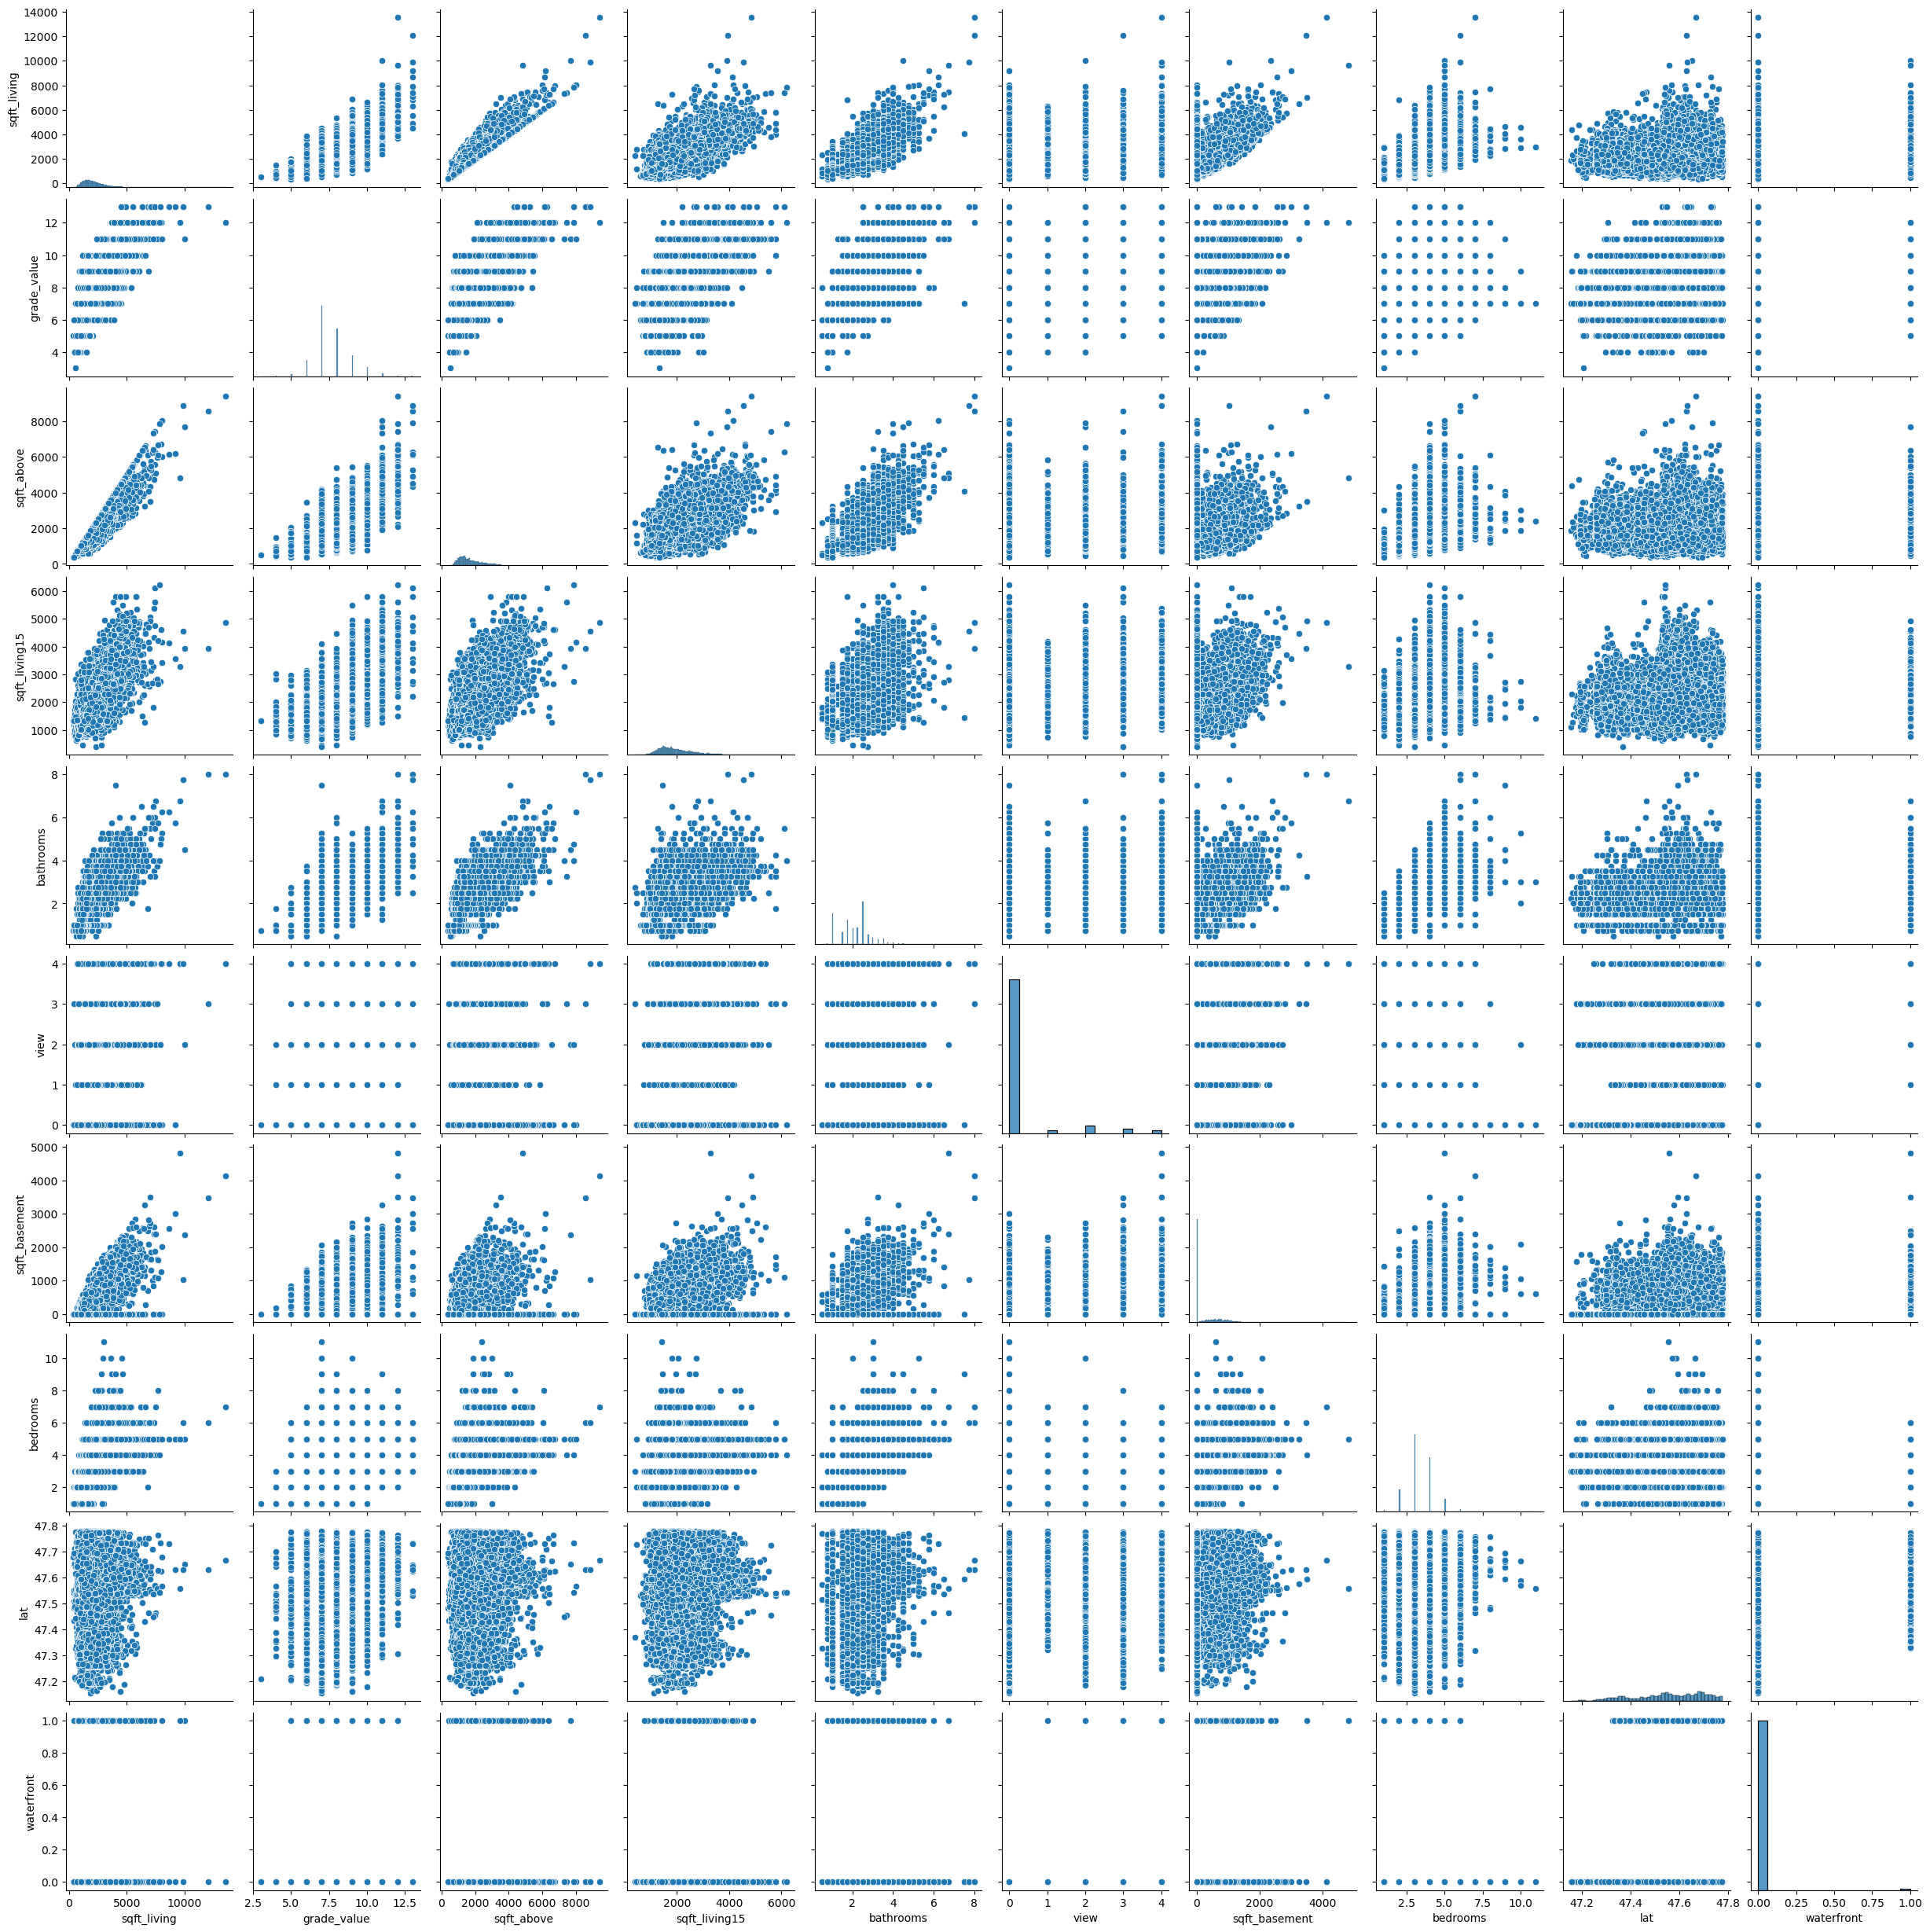

In [31]:
sns.pairplot(top_10)

In [32]:
house.groupby('waterfront').mean()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,sqft_above,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month,grade_value,yr_since_renovate
waterfront,,,,,,,,,,,,,,,,,,,,,
0,4.581430e+09,5.322812e+05,3.371981,2.111807,2072.417576,15026.516643,1.493193,0.209184,3.408858,1783.729930,...,1971.060140,66.540746,98077.822984,47.560226,-122.213540,1981.912168,12689.672214,6.571888,7.649930,42.037203
1,4.454969e+09,1.717215e+06,3.349315,2.708904,3244.753425,25870.883562,1.630137,3.787671,3.541096,2508.760274,...,1962.280822,395.013699,98096.712329,47.539677,-122.278164,2682.828767,22893.698630,6.883562,8.835616,44.472603


In [33]:
house.groupby('zipcode').mean().sort_values(by='price',ascending=False)

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,month,grade_value,yr_since_renovate
zipcode,,,,,,,,,,,,,,,,,,,,,
98039,3.755708e+09,2.161300e+06,4.060000,3.200000,3800.900000,17403.560000,1.560000,0.020000,0.440000,3.480000,...,510.000000,1972.520000,358.720000,47.625840,-122.233540,3132.200000,17291.100000,6.980000,9.560000,34.340000
98004,4.394237e+09,1.356524e+06,3.854890,2.527603,2909.022082,13104.220820,1.432177,0.003155,0.305994,3.495268,...,489.179811,1971.470032,176.671924,47.616183,-122.205189,2674.700315,12805.022082,6.353312,8.687697,39.028391
98040,4.199323e+09,1.194874e+06,4.028369,2.716312,3106.833333,13704.464539,1.505319,0.039007,0.780142,3.787234,...,632.503546,1971.471631,205.336879,47.559846,-122.225592,2898.744681,12801.283688,6.453901,8.960993,39.560284
98112,4.826282e+09,1.096239e+06,3.509294,2.373606,2498.743494,4990.431227,1.806691,0.000000,0.148699,3.516729,...,493.048327,1944.449814,156.107807,47.629619,-122.297866,2280.078067,4898.159851,6.762082,8.442379,64.646840
98102,4.102040e+09,8.996077e+05,3.250000,2.283654,2151.048077,3605.153846,1.990385,0.000000,0.153846,3.375000,...,398.605769,1952.163462,76.576923,47.634591,-122.322250,1954.471154,3303.500000,7.038462,8.298077,60.288462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98148,5.579459e+09,2.849086e+05,3.140351,1.793860,1610.526316,8960.719298,1.210526,0.000000,0.000000,3.070175,...,124.035088,1963.263158,34.596491,47.437437,-122.329316,1611.228070,8812.385965,6.578947,6.947368,50.964912
98001,4.651274e+09,2.811949e+05,3.393352,2.011773,1903.783934,14967.002770,1.430748,0.000000,0.094183,3.335180,...,180.027701,1980.867036,22.058172,47.309106,-122.270704,1830.099723,11218.875346,6.567867,7.296399,33.628809
98032,4.548921e+09,2.512962e+05,3.392000,1.708000,1738.048000,10379.760000,1.220000,0.000000,0.080000,3.632000,...,303.728000,1965.464000,31.984000,47.373556,-122.278848,1668.632000,9271.928000,6.800000,7.144000,48.896000


In [34]:
house.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month,grade_value,yr_since_renovate
count,2.159600e+04,2.159600e+04,21596.000000,21596.000000,21596.000000,2.159600e+04,21596.000000,21596.000000,21596.000000,21596.000000,...,21596.000000,21596.000000,21596.000000,21596.000000,21596.000000,21596.000000,21596.000000,21596.000000,21596.000000,21596.000000
mean,4.580575e+09,5.402920e+05,3.371828,2.115843,2080.343165,1.509983e+04,1.494119,0.006761,0.233377,3.409752,...,1971.000787,68.761391,98077.950685,47.560087,-122.213977,1986.650722,12758.656649,6.573995,7.657946,42.053667
std,2.876764e+09,3.673760e+05,0.904114,0.768998,918.122038,4.141355e+04,0.539685,0.081946,0.765116,0.650471,...,29.375460,364.045627,53.514040,0.138552,0.140725,685.231768,27275.018316,3.115131,1.173218,28.945525
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,...,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000,1.000000,3.000000,0.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,...,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000,4.000000,7.000000,16.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.619000e+03,1.500000,0.000000,0.000000,3.000000,...,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000,6.000000,7.000000,38.000000
75%,7.308950e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068550e+04,2.000000,0.000000,0.000000,4.000000,...,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000,9.000000,8.000000,61.000000
max,9.900000e+09,7.700000e+06,11.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,...,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000,12.000000,13.000000,115.000000


In [35]:
house.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21596 entries, 0 to 21596
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 21596 non-null  int64         
 1   date               21596 non-null  datetime64[ns]
 2   price              21596 non-null  float64       
 3   bedrooms           21596 non-null  int64         
 4   bathrooms          21596 non-null  float64       
 5   sqft_living        21596 non-null  int64         
 6   sqft_lot           21596 non-null  int64         
 7   floors             21596 non-null  float64       
 8   waterfront         21596 non-null  int64         
 9   view               21596 non-null  float64       
 10  condition          21596 non-null  int64         
 11  grade              21596 non-null  object        
 12  sqft_above         21596 non-null  int64         
 13  sqft_basement      21596 non-null  int64         
 14  yr_bui

In [36]:
house.yr_renovated.value_counts()

0.0       20852
2014.0       73
2013.0       31
2003.0       31
2007.0       30
          ...  
1951.0        1
1953.0        1
1946.0        1
1976.0        1
1948.0        1
Name: yr_renovated, Length: 70, dtype: int64